## Forward-Design (again) 

## Imports

In [17]:
import sys; sys.path.append('../..')
import inflation, mesh, sheet_meshing
from tri_mesh_viewer import OffscreenTriMeshViewer
import numpy as np
import utils, py_newton_optimizer, benchmark
import matplotlib.pyplot as pltRun
from scipy.spatial import KDTree
from tri_mesh_viewer import TriMeshViewer as Viewer

## Load Mesh and Fused Points

In [18]:
V, E = mesh.load_raw('../data/ForwardDesign/hinge.obj')
fusedPts = list(np.loadtxt('../data/ForwardDesign/fusehingev3.txt').reshape((-1, 2)))
holePts = []

## Create Inflatable Sheet Mesh

In [19]:
m, iwv, iwbv = sheet_meshing.forward_design_mesh(V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4)
isheet = inflation.InflatableSheet(m, iwv)

## Set Up Offscreen Viewer for Video Recording

In [20]:
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)

 ## Define and Find Tracked Vertices

In [21]:
target_points = np.array([
    [5.0,  0.0, 0.0],
    [5.0, 20.0, 0.0],
    [5.0, 40.0, 0.0]
])

V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])
tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]
print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])

Tracked indices: [184, 294, 237]
Tracked coordinates: [array([5., 0., 0.]), array([ 5., 20.,  0.]), array([ 5., 40.,  0.])]


## Set Up Tracking and Callback

In [22]:
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # Save every 5 iterations

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        oview.update()  # Update offscreen viewer for video

## Run Simulation and Record Video

In [23]:
viewer = Viewer(isheet, wireframe=True)
viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [24]:
benchmark.reset()
oview.recordStart('tracked_inflation2.mp4')
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.niter = 500
isheet.pressure = 1
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()
oview.recordStop()

InflatableSheet setVars	0.0184669	1
Newton iterations	72.833	1
    InflatableSheet energy	0.000437975	1
    Newton iterate	72.832	114
        Backtracking	0.657964	113
            InflatableSheet energy	0.132653	165
            InflatableSheet setVars	0.509105	165
        Compute descent direction	69.945	113
            Negative curvature dir	0.197972	3
                negativeCurvatureDirection	0.189597	3
                    CHOLMOD Backsub	0.140318	51
                    CHOLMOD Numeric Factorize	0.00351882	3
                    CHOLMOD Symbolic Factorize	0.0304127	3
            newton_step	69.746	113
                Newton solve	66.3842	193
                    CHOLMOD Numeric Factorize	64.2763	192
                    Solve	1.50784	114
                        CHOLMOD Backsub	1.15893	113
                        CHOLMOD Numeric Factorize	0.053328	1
                        CHOLMOD Symbolic Factorize	0.270973	1
                hessEval	3.23703	113
                largestMagnitudeEigenval

## Export Inflated Mesh as OBJ

In [25]:
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))  # OBJ is 1-indexed

V_raw, F_raw, *_ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_raw], dtype=np.float64)
F = np.array([f for f in F_raw], dtype=np.int32)
write_obj("inflated_mesh2.obj", V, F)

## Plot Z Displacement Over Time

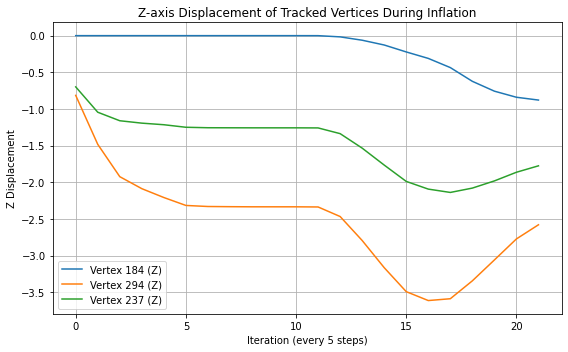

In [26]:
plt.figure(figsize=(8, 5))
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 2], label=f"Vertex {idx} (Z)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Z Displacement")
plt.title("Z-axis Displacement of Tracked Vertices During Inflation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 3D Trajectories

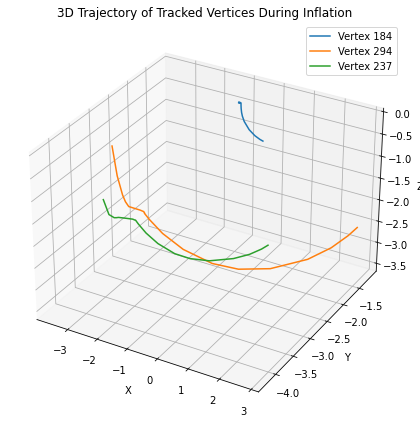

In [27]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()

 ## Plot X and Y Displacement

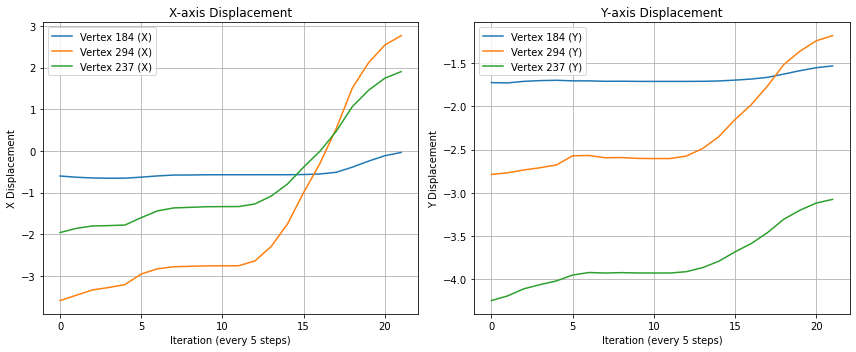

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 0], label=f"Vertex {idx} (X)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("X Displacement")
plt.title("X-axis Displacement")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 1], label=f"Vertex {idx} (Y)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Y Displacement")
plt.title("Y-axis Displacement")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

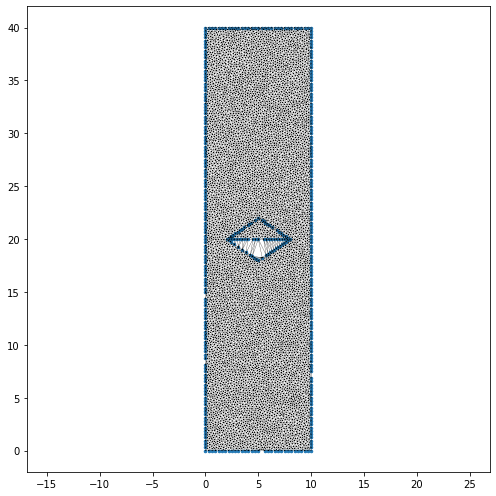

In [29]:
import visualization
visualization.plot_2d_mesh(m, pointList=np.where(iwv))

In [30]:
viewer = Viewer(isheet, wireframe=True)
viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…